# Algorithm Validation

**(Jan 18, 2025)**

**Description:** We use the truth data on Inititiative 83 petitions to validate the algorithm. We want to record the performance of the algorithm in terms of accuracy, precision, recall, and F1 score. We also want to record the cost of the algorithm in terms of the number of pages processed and the cost of the API calls.


We are interested in metrics for both the positive and negative classes, i.e., metrics for the case where signatures are valid and for the case where signatures are invalid. What we want to know:

- **Positive Class:**
    - What proportion of signatures that are predicted to be valid are actually valid? (positive class precision)
    - What proportion of valid signatures are predicted to be valid? (positive class recall)

- **Negative Class:**
    - What proportion of signatures that are predicted to be invalid are actually invalid? (negative class precision)
    - What proportion of invalid signatures are predicted to be invalid? (negative class recall)

- **True Positive Rate (TPR) and False Positive Rate (FPR):**
    - What is the True Positive Rate (TPR) and False Positive Rate (FPR) for the positive class?
    - What is the True Positive Rate (TPR) and False Positive Rate (FPR) for the negative class?

- **AUC Score:**
    - What is the AUC score for the algorithm? (ROC AUC score is the same for both positive and negative classes)

All of these questions besides the last one depend on the threshold value. We will set the threshold value based on the following criteria:
- Precision $\simeq$ Recall
- $\text{max}$(TPR - FPR)
Namely, we will set the threshold value based on the point where precision and recall are approximately equal. We will also set the threshold value based on the point where the difference between TPR and FPR is maximized.

(For privacy reasons, we will not show the output of the data used for this analysis, and will only display the metrics)

----------

In [1]:
# from ocr_matching_functions_2024_09 import *
import sys
sys.path.append('../..')  # Add parent directory to Python path
from app.ocr_helper import *
from app.fuzzy_match_helper import *
import matplotlib.pyplot as plt
import numpy as np
import time
# compute the accuracy, precision, recall, and F1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

%matplotlib inline


In [2]:
# get scikit-learn version
import sklearn
sklearn.__version__

# get matplotlib version
import matplotlib
matplotlib.__version__


'3.10.0'

#### Running the Algorithm

In [3]:

"""
Code that has already been run: Uncomment to run again
"""
# # timing the result
# start_time = time.time()

# # creating ocr data frame from voter pdfs
# ocr_df = create_ocr_df(filedir=f"../Initiative Measure No. 83 Petition Sheets", filename="I-83 - p 0001-0100.pdf")

# # recording elapsed time; uncomment in the notebook run
# print(f'\nElapsed Time: {time.time()-start_time:.3f} secs')

'\nCode that has already been run: Uncomment to run again\n'

In [4]:
# getting voter records
voter_records = pd.read_csv("../06-04-2024 City Wide.csv")

# getting only necessary information
select_voter_records = create_select_voter_records(voter_records)

In [5]:
"""
Code that has already been run: Uncomment to run again
"""

# timing the result
# start_time = time.time()

# # creating new matched DF
# ocr_matched_df = create_ocr_matched_df(ocr_df, select_voter_records, threshold = 85)

# # recording elapsed time; uncomment in the notebook run
# print(f'\nElapsed Time: {time.time()-start_time:.3f} secs')

# save the ocr matched df
# ocr_matched_df.to_csv("ocr_matched_df_threshold_85.csv", index=False)


'\nCode that has already been run: Uncomment to run again\n'

In [6]:
# load the ocr matched df
ocr_matched_df = pd.read_csv("ocr_matched_df_threshold_85.csv")


#### Loading Truth Data

In [7]:
# import validated petitions
import pandas as pd

validated_petitions = pd.read_csv(f'100_petitions_validation_dc.csv')

# create new "valid" column based on "finding" 
validated_petitions['true_valid'] = validated_petitions['finding'].apply(lambda x: True if x == 'OK' else False)

# hide PII
# validated_petitions.head()


In [8]:
# count the number of true_valid values
validated_petitions['true_valid'].value_counts()

true_valid
True     390
False    110
Name: count, dtype: int64

In [9]:
# Count the non empty rows for voter_name
validated_petitions['voter_name'].notna().sum()

445

#### Merging Predictions with Truth Data

In [10]:
# merge the ocr_matched_df with the validated_petitions using Matched Name and voter_name
merged_df = pd.merge(
    right=validated_petitions, 
    left=ocr_matched_df,
    how='right',
    left_on=['Page Number', 'Row Number'],
    right_on=['page', 'line'],
)

# hiding PII
# merged_df.head()


In [11]:
# only keep the columns 'OCR Name', 'Matched Name', 'OCR Address', 'Matched Address', 'Match Score','valid', 'true_valid'
merged_df = merged_df[['OCR Name', 'Matched Name', 'OCR Address', 'Matched Address', 'voter_name', 'address', 'Match Score', 'true_valid']]

# define predicted_valid as True if Match Score is greater than 85
merged_df['predicted_valid'] = merged_df['Match Score'] > 85

# remove nan values
merged_df = merged_df.dropna()

# hide PII
# merged_df.head(20)

In [12]:
# compute minimum match score; all petitions with scores above this value are predicted to be valid
min(merged_df['Match Score'])

35.77235772357723

In [13]:
# true list 
true_list = [1 if x else 0 for x in merged_df['true_valid'].tolist()]

# pred_prob
pred_prob = np.array(merged_df['Match Score'].tolist())/100

# function to compute predicted_list based on threshold
predicted_list_func = lambda threshold: [1 if x >= threshold else 0 for x in merged_df['Match Score'].tolist()]


In [14]:
# getting threshold values
threshold_values = np.linspace(0, 100, 100)

In [15]:
results_list = []

for threshold in threshold_values:  
    temp_dict = {}
    temp_dict['threshold'] = threshold

    # getting predicted list
    predicted_list = predicted_list_func(threshold)

    # getting accuracy, precision, recall, and f1 score
    temp_dict['accuracy'] = accuracy_score(true_list, predicted_list)
    temp_dict['precision'] = precision_score(true_list, predicted_list)
    temp_dict['recall'] = recall_score(true_list, predicted_list)
    temp_dict['f1'] = f1_score(true_list, predicted_list)

    # getting true positive rate and false positive rate from confusion matrix
    matrix = confusion_matrix(true_list, predicted_list)
    temp_dict['TPR'] = matrix[1, 1] / (matrix[1, 1] + matrix[1, 0])
    temp_dict['FPR'] = matrix[0, 1] / (matrix[0, 1] + matrix[0, 0])

    # appending the results to the results list
    results_list.append(temp_dict)

scores_df = pd.DataFrame(results_list)


In [16]:
scores_df

,threshold,accuracy,precision,recall,f1,TPR,FPR
0,0.000000,0.876993,0.876993,1.000000,0.934466,1.000000,1.000000
1,1.010101,0.876993,0.876993,1.000000,0.934466,1.000000,1.000000
2,2.020202,0.876993,0.876993,1.000000,0.934466,1.000000,1.000000
3,3.030303,0.876993,0.876993,1.000000,0.934466,1.000000,1.000000
4,4.040404,0.876993,0.876993,1.000000,0.934466,1.000000,1.000000
...,...,...,...,...,...,...,...
95,95.959596,0.225513,0.978723,0.119481,0.212963,0.119481,0.018519
96,96.969697,0.186788,0.966667,0.075325,0.139759,0.075325,0.018519
97,97.979798,0.179954,1.000000,0.064935,0.121951,0.064935,0.000000
98,98.989899,0.175399,1.000000,0.059740,0.112745,0.059740,0.000000


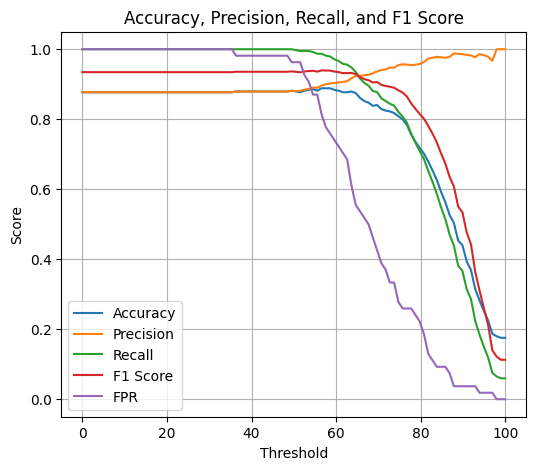

In [17]:
# plot the accuracy, precision, recall, and f1 score
plt.figure(figsize=(6, 5))
plt.plot(scores_df['threshold'], scores_df['accuracy'], label='Accuracy')
plt.plot(scores_df['threshold'], scores_df['precision'], label='Precision')
plt.plot(scores_df['threshold'], scores_df['recall'], label='Recall')
plt.plot(scores_df['threshold'], scores_df['f1'], label='F1 Score')
plt.plot(scores_df['threshold'], scores_df['FPR'], label='FPR')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy, Precision, Recall, and F1 Score')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# find point where precision and recall are approximately equal
print(scores_df.loc[(scores_df['precision'] - scores_df['recall'] < 0.01) & (scores_df['precision'] - scores_df['recall'] > -0.01)])

    threshold  accuracy  precision    recall        f1       TPR       FPR
65  65.656566  0.861048   0.924084  0.916883  0.920469  0.916883  0.537037


In [19]:
# find threshold where difference between TPR and FPR is maximized
scores_df.loc[(scores_df['TPR'] - scores_df['FPR']).idxmax()]


threshold    75.757576
accuracy      0.799544
precision     0.956923
recall        0.807792
f1            0.876056
TPR           0.807792
FPR           0.259259
Name: 75, dtype: float64

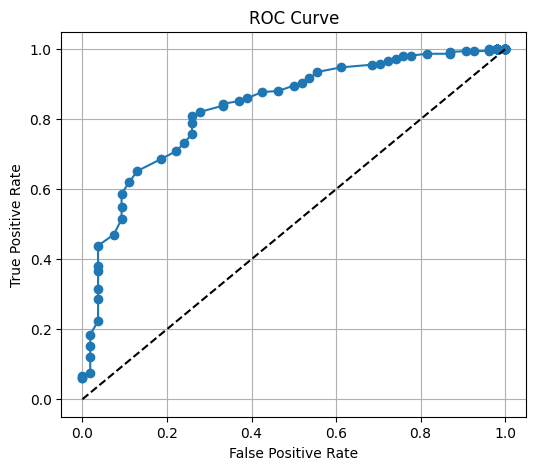

In [20]:
# Plotting ROC Curve

# Convert results list to DataFrame for easier plotting
# Create ROC curve plot
plt.figure(figsize=(6, 5))
plt.plot(scores_df['FPR'], scores_df['TPR'], marker='o')
plt.plot([0, 1], [0, 1], 'k--')  # Add diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()




In [21]:
# ROC AUC Score
roc_auc_score(true_list, pred_prob)

0.8344155844155844

#### Computing Metrics for Negative Class

In [22]:
# Disable all warnings and logging
import warnings
warnings.simplefilter("ignore")

# compute true list for the negative class
true_list_neg = [0 if x else 1 for x in merged_df['true_valid'].tolist()]

results_neg_list = []

for threshold in threshold_values:  
    temp_dict = {}
    
    temp_dict['threshold'] = threshold

    # getting predicted list
    predicted_list = predicted_list_func(threshold)

    predicted_list_neg = [0 if x else 1 for x in predicted_list]

    # getting accuracy, precision, recall, and f1 score
    temp_dict['accuracy'] = accuracy_score(true_list_neg, predicted_list_neg)
    temp_dict['precision'] = (np.array(predicted_list_neg) & np.array(true_list_neg)).mean() / np.array(predicted_list_neg).mean()
    temp_dict['recall'] = recall_score(true_list_neg, predicted_list_neg)
    temp_dict['f1'] = f1_score(true_list_neg, predicted_list_neg)

    # getting true positive rate and false positive rate from confusion matrix
    matrix = confusion_matrix(true_list_neg, predicted_list_neg)
    temp_dict['TPR'] = matrix[1, 1] / (matrix[1, 1] + matrix[1, 0])
    temp_dict['FPR'] = matrix[0, 1] / (matrix[0, 1] + matrix[0, 0])

    # appending the results to the results list
    results_neg_list.append(temp_dict)

scores_neg_df = pd.DataFrame(results_neg_list)

scores_neg_df

,threshold,accuracy,precision,recall,f1,TPR,FPR
0,0.000000,0.876993,NaN,0.000000,0.000000,0.000000,0.000000
1,1.010101,0.876993,NaN,0.000000,0.000000,0.000000,0.000000
2,2.020202,0.876993,NaN,0.000000,0.000000,0.000000,0.000000
3,3.030303,0.876993,NaN,0.000000,0.000000,0.000000,0.000000
4,4.040404,0.876993,NaN,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
95,95.959596,0.225513,0.135204,0.981481,0.237668,0.981481,0.880519
96,96.969697,0.186788,0.129584,0.981481,0.228942,0.981481,0.924675
97,97.979798,0.179954,0.130435,1.000000,0.230769,1.000000,0.935065
98,98.989899,0.175399,0.129808,1.000000,0.229787,1.000000,0.940260


In [23]:
# find point where precision and recall are approximately equal
print(scores_neg_df[(scores_neg_df['precision'] - scores_neg_df['recall'] < 0.03) & (scores_neg_df['precision'] - scores_neg_df['recall'] > -0.03)])    

    threshold  accuracy  precision    recall       f1       TPR       FPR
65  65.656566  0.861048   0.438596  0.462963  0.45045  0.462963  0.083117


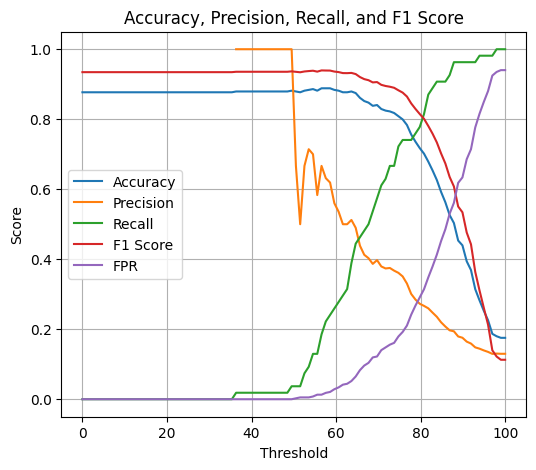

In [24]:
# plot the accuracy, precision, recall, and f1 score
plt.figure(figsize=(6, 5))
plt.plot(scores_neg_df['threshold'], scores_neg_df['accuracy'], label='Accuracy')
plt.plot(scores_neg_df['threshold'], scores_neg_df['precision'], label='Precision')
plt.plot(scores_neg_df['threshold'], scores_neg_df['recall'], label='Recall')
plt.plot(scores_df['threshold'], scores_df['f1'], label='F1 Score')
# plt.plot(scores_df['threshold'], scores_df['TPR'], label='TPR') # recall is TPR
plt.plot(scores_neg_df['threshold'], scores_neg_df['FPR'], label='FPR')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy, Precision, Recall, and F1 Score')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# find threshold where difference between TPR and FPR is maximized
scores_neg_df.loc[(scores_neg_df['TPR'] - scores_neg_df['FPR']).idxmax()]

threshold    75.757576
accuracy      0.799544
precision     0.350877
recall        0.740741
f1            0.476190
TPR           0.740741
FPR           0.192208
Name: 75, dtype: float64

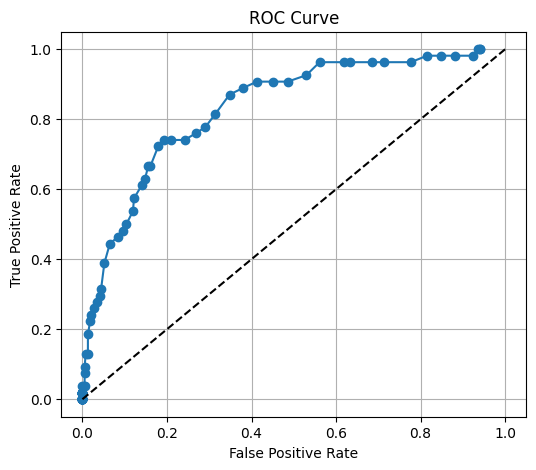

In [26]:
# Plotting ROC Curve for Negative Class

# Convert results list to DataFrame for easier plotting
# Create ROC curve plot
plt.figure(figsize=(6, 5))
plt.plot(scores_neg_df['FPR'], scores_neg_df['TPR'], marker='o')
plt.plot([0, 1], [0, 1], 'k--')  # Add diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()




In [27]:
# compute true list for the negative class
true_list_neg = [0 if x else 1 for x in merged_df['true_valid'].tolist()]

# compute predicted probability for the negative class
pred_prob_neg = 1 - np.array(merged_df['Match Score'].tolist())/100

# ROC AUC Score; note that this is the same as the ROC AUC Score for the positive class
roc_auc_score(true_list_neg, pred_prob_neg)

0.8344155844155845

#### Conclusion


#### Stats for Threshold based on Precision \simeq Recall
Based on recall and precision, we set the threshold at the value where recall and precision are approximately equal. This is at a threshold of **65.56**. At this threshold, the stats for the positive class are:

| threshold | accuracy | precision | recall | f1 | TPR | FPR |
|-----------|----------|-----------|--------|----|----|-----|
| 65.656566 | 0.861048 | 0.924084 | 0.916883 | 0.920469 | 0.916883 | 0.537037 |

and the stats for the negative class are:

| threshold | accuracy | precision | recall | f1 | TPR | FPR |
|-----------|----------|-----------|--------|----|----|-----|
| 65.656566 | 0.861048 | 0.438596 | 0.462963 | 0.45045 | 0.462963 | 0.083117 |


#### Stats for Threshold based on $\text{max}$(TPR - FPR)

Based on the difference between TPR and FPR, we set the threshold at the value where the difference between TPR and FPR is maximized. This is at a threshold of **75.75**. At this threshold, the stats for the positive class are:


| threshold | accuracy | precision | recall | f1 | TPR | FPR |
|-----------|----------|-----------|--------|-----|-----|-----|
| 75.757576 | 0.799544 | 0.956923 | 0.807792 | 0.876056 | 0.807792 | 0.259259 |

and the stats for the negative class are:

| threshold | accuracy | precision | recall | f1 | TPR | FPR |
|-----------|----------|-----------|--------|-----|-----|-----|
| 75.757576 | 0.799544 | 0.350877 | 0.740741 | 0.476190 | 0.740741 | 0.192208 |

#### AUC Score

The AUC score for the algorithm is **0.83**. We can use this as a baseline performance metric for the algorithm. Other relevant factors are the cost of the algorithm and computation time (for a set number of pages).


